# Stress-Only Trading Strategy

**Hypothesis:** Trade ONLY during stress periods when mean reversion is strongest.

Statistical tests showed:
- **Low stress (Regime 0):** Mean reversion exists but weak
- **High stress (Regime 1):** Mean reversion is MUCH stronger (Sharpe -8.58 at 21d)

Current strategy avoided stress. Let's try the **opposite**: trade ONLY during stress.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Setup complete")

✓ Setup complete


## Load Data & Analyze Stress Periods

In [2]:
df = pd.read_csv('../data/processed/full_processed_data_hmm.csv', index_col=0, parse_dates=True)

print(f"Full dataset: {len(df)} observations ({df.index.min().date()} to {df.index.max().date()})")

# Analyze stress periods
stress_regime = df[df['regime'] == 1]
high_vix = df[df['vix'] > 30]
either_stress = df[(df['regime'] == 1) | (df['vix'] > 30)]

print(f"\nStress period analysis:")
print(f"  Regime 1 (high stress): {len(stress_regime)} days ({len(stress_regime)/len(df):.1%})")
print(f"  VIX > 30: {len(high_vix)} days ({len(high_vix)/len(df):.1%})")
print(f"  Either condition: {len(either_stress)} days ({len(either_stress)/len(df):.1%})")

print(f"\nSpread during stress vs calm:")
print(f"  Calm (Regime 0): Mean={df[df['regime']==0]['spread'].mean():.2f} bps, Std={df[df['regime']==0]['spread'].std():.2f} bps")
print(f"  Stress (Regime 1): Mean={df[df['regime']==1]['spread'].mean():.2f} bps, Std={df[df['regime']==1]['spread'].std():.2f} bps")
print(f"  Difference: {df[df['regime']==1]['spread'].mean() - df[df['regime']==0]['spread'].mean():.2f} bps wider during stress")

Full dataset: 2887 observations (2015-01-29 to 2025-12-30)

Stress period analysis:
  Regime 1 (high stress): 753 days (26.1%)
  VIX > 30: 164 days (5.7%)
  Either condition: 755 days (26.2%)

Spread during stress vs calm:
  Calm (Regime 0): Mean=1.14 bps, Std=0.23 bps
  Stress (Regime 1): Mean=1.53 bps, Std=0.40 bps
  Difference: 0.39 bps wider during stress


## Visualize Stress Periods

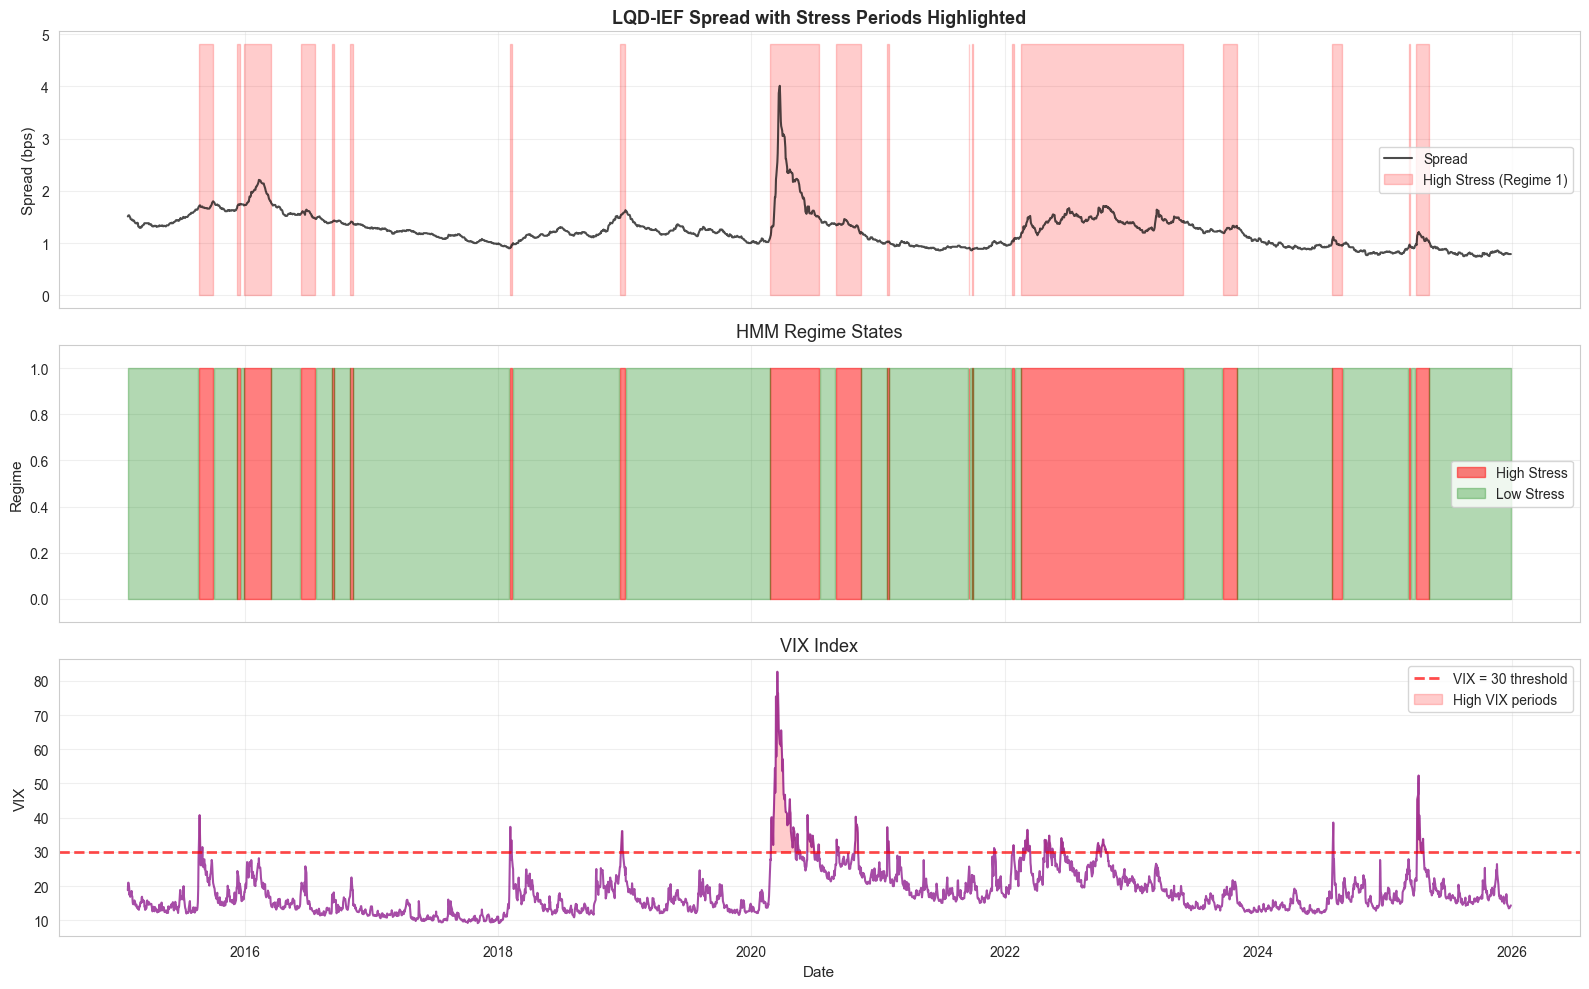

✓ Stress periods visualized


In [3]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Spread
axes[0].plot(df.index, df['spread'], linewidth=1.5, color='black', alpha=0.7, label='Spread')
# Highlight stress periods
axes[0].fill_between(df.index, 0, df['spread'].max() * 1.2, 
                      where=(df['regime'] == 1), color='red', alpha=0.2, label='High Stress (Regime 1)')
axes[0].set_ylabel('Spread (bps)', fontsize=11)
axes[0].set_title('LQD-IEF Spread with Stress Periods Highlighted', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Regime
axes[1].fill_between(df.index, 0, 1, where=(df['regime'] == 1), 
                      color='red', alpha=0.5, label='High Stress')
axes[1].fill_between(df.index, 0, 1, where=(df['regime'] == 0), 
                      color='green', alpha=0.3, label='Low Stress')
axes[1].set_ylabel('Regime', fontsize=11)
axes[1].set_title('HMM Regime States', fontsize=13)
axes[1].legend()
axes[1].set_ylim([-0.1, 1.1])
axes[1].grid(True, alpha=0.3)

# VIX
axes[2].plot(df.index, df['vix'], linewidth=1.5, color='purple', alpha=0.7)
axes[2].axhline(y=30, color='red', linestyle='--', linewidth=2, label='VIX = 30 threshold', alpha=0.7)
axes[2].fill_between(df.index, 30, df['vix'], where=(df['vix'] > 30), 
                      color='red', alpha=0.2, label='High VIX periods')
axes[2].set_ylabel('VIX', fontsize=11)
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_title('VIX Index', fontsize=13)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/stress_periods_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Stress periods visualized")

## Strategy 1: Trade ONLY During Regime 1 (High Stress)

In [4]:
def backtest_stress_only(
    data: pd.DataFrame,
    stress_type: str = 'regime',  # 'regime', 'vix', or 'either'
    vix_threshold: float = 30,
    entry_z: float = 1.5,  # Lower threshold - easier to enter during stress
    exit_z: float = 0.5,
    window: int = 40,
    position_size: float = 0.5,
    capital: float = 1_000_000
) -> pd.DataFrame:
    """
    Trade ONLY during stress periods.
    
    stress_type:
    - 'regime': Trade only when regime == 1
    - 'vix': Trade only when VIX > threshold  
    - 'either': Trade when regime == 1 OR VIX > threshold
    """
    results = []
    position = 0
    equity = capital
    notional = capital * position_size
    
    for i in range(window, len(data)):
        current_spread = data['spread'].iloc[i]
        regime = data['regime'].iloc[i]
        vix = data['vix'].iloc[i]
        
        # Determine if we're in stress
        if stress_type == 'regime':
            in_stress = (regime == 1)
        elif stress_type == 'vix':
            in_stress = (vix > vix_threshold)
        else:  # 'either'
            in_stress = (regime == 1) or (vix > vix_threshold)
        
        # Calculate z-score
        hist = data['spread'].iloc[i-window:i]
        mean = hist.mean()
        std = hist.std()
        z_score = (current_spread - mean) / std if std > 0 else 0
        
        # Signal generation
        signal = position
        
        # Exit when stress ends OR mean reverts
        if position != 0:
            if not in_stress:  # Exit when stress ends
                signal = 0
            elif abs(z_score) < exit_z:  # Or when mean reverted
                signal = 0
        
        # Entry ONLY during stress
        elif position == 0 and in_stress:
            if z_score > entry_z:
                signal = -1  # Short spread (expect reversion down)
            elif z_score < -entry_z:
                signal = +1  # Long spread (expect reversion up)
        
        # P&L
        pnl = 0
        if i > window and position != 0:
            spread_chg = (current_spread - data['spread'].iloc[i-1]) / 10000
            pnl = spread_chg * notional if position == 1 else -spread_chg * notional
        
        equity += pnl
        position = signal
        
        results.append({
            'spread': current_spread,
            'z_score': z_score,
            'regime': regime,
            'vix': vix,
            'in_stress': in_stress,
            'position': position,
            'pnl': pnl,
            'equity': equity,
        })
    
    return pd.DataFrame(results, index=data.index[window:])

print("✓ Stress-only strategy defined")

✓ Stress-only strategy defined


## Test All Stress Definitions

In [5]:
print("Testing Stress-Only Strategies (ZERO COSTS)")
print("="  * 80)

# Run on full dataset
results_regime = backtest_stress_only(df, stress_type='regime', entry_z=1.5, exit_z=0.5)
results_vix = backtest_stress_only(df, stress_type='vix', vix_threshold=30, entry_z=1.5, exit_z=0.5)
results_either = backtest_stress_only(df, stress_type='either', vix_threshold=30, entry_z=1.5, exit_z=0.5)

# Also test more aggressive entry during stress
results_aggressive = backtest_stress_only(df, stress_type='regime', entry_z=1.0, exit_z=0.3, window=20)

# Calculate metrics
def calc_metrics(results, capital=1_000_000):
    total_ret = (results['equity'].iloc[-1] - capital) / capital
    daily_ret = results['pnl'] / capital
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0
    running_max = results['equity'].expanding().max()
    dd = (results['equity'] - running_max) / running_max
    max_dd = dd.min()
    n_trades = (results['position'].diff().fillna(0) != 0).sum() // 2
    win_days = (daily_ret > 0).sum()
    lose_days = (daily_ret < 0).sum()
    win_rate = win_days / (win_days + lose_days) if (win_days + lose_days) > 0 else 0
    
    # Time in market
    time_in_market = (results['position'] != 0).sum() / len(results)
    
    return {
        'return': total_ret,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'trades': int(n_trades),
        'win_rate': win_rate,
        'time_in_market': time_in_market,
        'final_equity': results['equity'].iloc[-1],
    }

metrics_regime = calc_metrics(results_regime)
metrics_vix = calc_metrics(results_vix)
metrics_either = calc_metrics(results_either)
metrics_aggressive = calc_metrics(results_aggressive)

# Create comparison
comparison = pd.DataFrame({
    'Regime 1 Only': metrics_regime,
    'VIX > 30 Only': metrics_vix,
    'Either Stress': metrics_either,
    'Aggressive (Regime 1)': metrics_aggressive,
})

print("\nStress-Only Strategy Comparison (2015-2025):")
print(comparison.T.to_string())

print(f"\n\nDetailed Results:")
for strategy in comparison.columns:
    print(f"\n{strategy}:")
    print(f"  Return: {comparison.loc['return', strategy]:.2%}")
    print(f"  Sharpe: {comparison.loc['sharpe', strategy]:.2f}")
    print(f"  Max DD: {comparison.loc['max_dd', strategy]:.2%}")
    print(f"  Trades: {int(comparison.loc['trades', strategy])}")
    print(f"  Win rate: {comparison.loc['win_rate', strategy]:.2%}")
    print(f"  Time in market: {comparison.loc['time_in_market', strategy]:.2%}")
    print(f"  P&L: ${comparison.loc['final_equity', strategy] - 1_000_000:,.2f}")

Testing Stress-Only Strategies (ZERO COSTS)

Stress-Only Strategy Comparison (2015-2025):
                         return    sharpe    max_dd  trades  win_rate  time_in_market  final_equity
Regime 1 Only         -0.000140 -0.706020 -0.000167    30.0  0.441860        0.156656      999860.5
VIX > 30 Only         -0.000089 -0.493682 -0.000141    17.0  0.459770        0.035827      999911.0
Either Stress         -0.000140 -0.705969 -0.000167    32.0  0.442197        0.157359      999860.5
Aggressive (Regime 1) -0.000246 -1.218484 -0.000257    40.0  0.413646        0.219393      999754.0


Detailed Results:

Regime 1 Only:
  Return: -0.01%
  Sharpe: -0.71
  Max DD: -0.02%
  Trades: 30
  Win rate: 44.19%
  Time in market: 15.67%
  P&L: $-139.50

VIX > 30 Only:
  Return: -0.01%
  Sharpe: -0.49
  Max DD: -0.01%
  Trades: 17
  Win rate: 45.98%
  Time in market: 3.58%
  P&L: $-89.00

Either Stress:
  Return: -0.01%
  Sharpe: -0.71
  Max DD: -0.02%
  Trades: 32
  Win rate: 44.22%
  Time in market

## Compare vs Always-On Strategy

In [6]:
# Run normal strategy (avoid stress) for comparison
def backtest_avoid_stress(data, window=60, entry_z=2.0, exit_z=0.5, position_size=0.5, capital=1_000_000):
    results = []
    position = 0
    equity = capital
    notional = capital * position_size
    
    for i in range(window, len(data)):
        current_spread = data['spread'].iloc[i]
        regime = data['regime'].iloc[i]
        vix = data['vix'].iloc[i]
        
        hist = data['spread'].iloc[i-window:i]
        mean = hist.mean()
        std = hist.std()
        z_score = (current_spread - mean) / std if std > 0 else 0
        
        signal = position
        if position != 0 and abs(z_score) < exit_z:
            signal = 0
        elif position == 0:
            if z_score > entry_z:
                signal = -1
            elif z_score < -entry_z:
                signal = +1
        
        # AVOID stress
        if regime == 1:
            if position == 0:
                signal = 0
            else:
                signal = 0
        if vix > 30 and position == 0:
            signal = 0
        
        pnl = 0
        if i > window and position != 0:
            spread_chg = (current_spread - data['spread'].iloc[i-1]) / 10000
            pnl = spread_chg * notional if position == 1 else -spread_chg * notional
        
        equity += pnl
        position = signal
        results.append({'position': position, 'pnl': pnl, 'equity': equity})
    
    return pd.DataFrame(results, index=data.index[window:])

results_avoid = backtest_avoid_stress(df, window=60, entry_z=2.0, exit_z=0.5)
metrics_avoid = calc_metrics(results_avoid)

# Final comparison
final_comparison = pd.DataFrame({
    'AVOID Stress (Original)': metrics_avoid,
    'ONLY Regime 1': metrics_regime,
    'ONLY VIX > 30': metrics_vix,
    'Aggressive Regime 1': metrics_aggressive,
})

print("\n" + "="*80)
print("FINAL COMPARISON: Avoid vs Only Stress")
print("="*80)
print("\n" + final_comparison.T.to_string())

# Calculate difference
print(f"\n\nP&L Comparison:")
for strategy in final_comparison.columns:
    pnl = final_comparison.loc['final_equity', strategy] - 1_000_000
    print(f"  {strategy:30s}: ${pnl:8,.2f}")


FINAL COMPARISON: Avoid vs Only Stress

                           return    sharpe    max_dd  trades  win_rate  time_in_market  final_equity
AVOID Stress (Original) -0.000064 -1.120803 -0.000069    32.0  0.416507        0.327909      999936.0
ONLY Regime 1           -0.000140 -0.706020 -0.000167    30.0  0.441860        0.156656      999860.5
ONLY VIX > 30           -0.000089 -0.493682 -0.000141    17.0  0.459770        0.035827      999911.0
Aggressive Regime 1     -0.000246 -1.218484 -0.000257    40.0  0.413646        0.219393      999754.0


P&L Comparison:
  AVOID Stress (Original)       : $  -64.00
  ONLY Regime 1                 : $ -139.50
  ONLY VIX > 30                 : $  -89.00
  Aggressive Regime 1           : $ -246.00


## Visualize Results

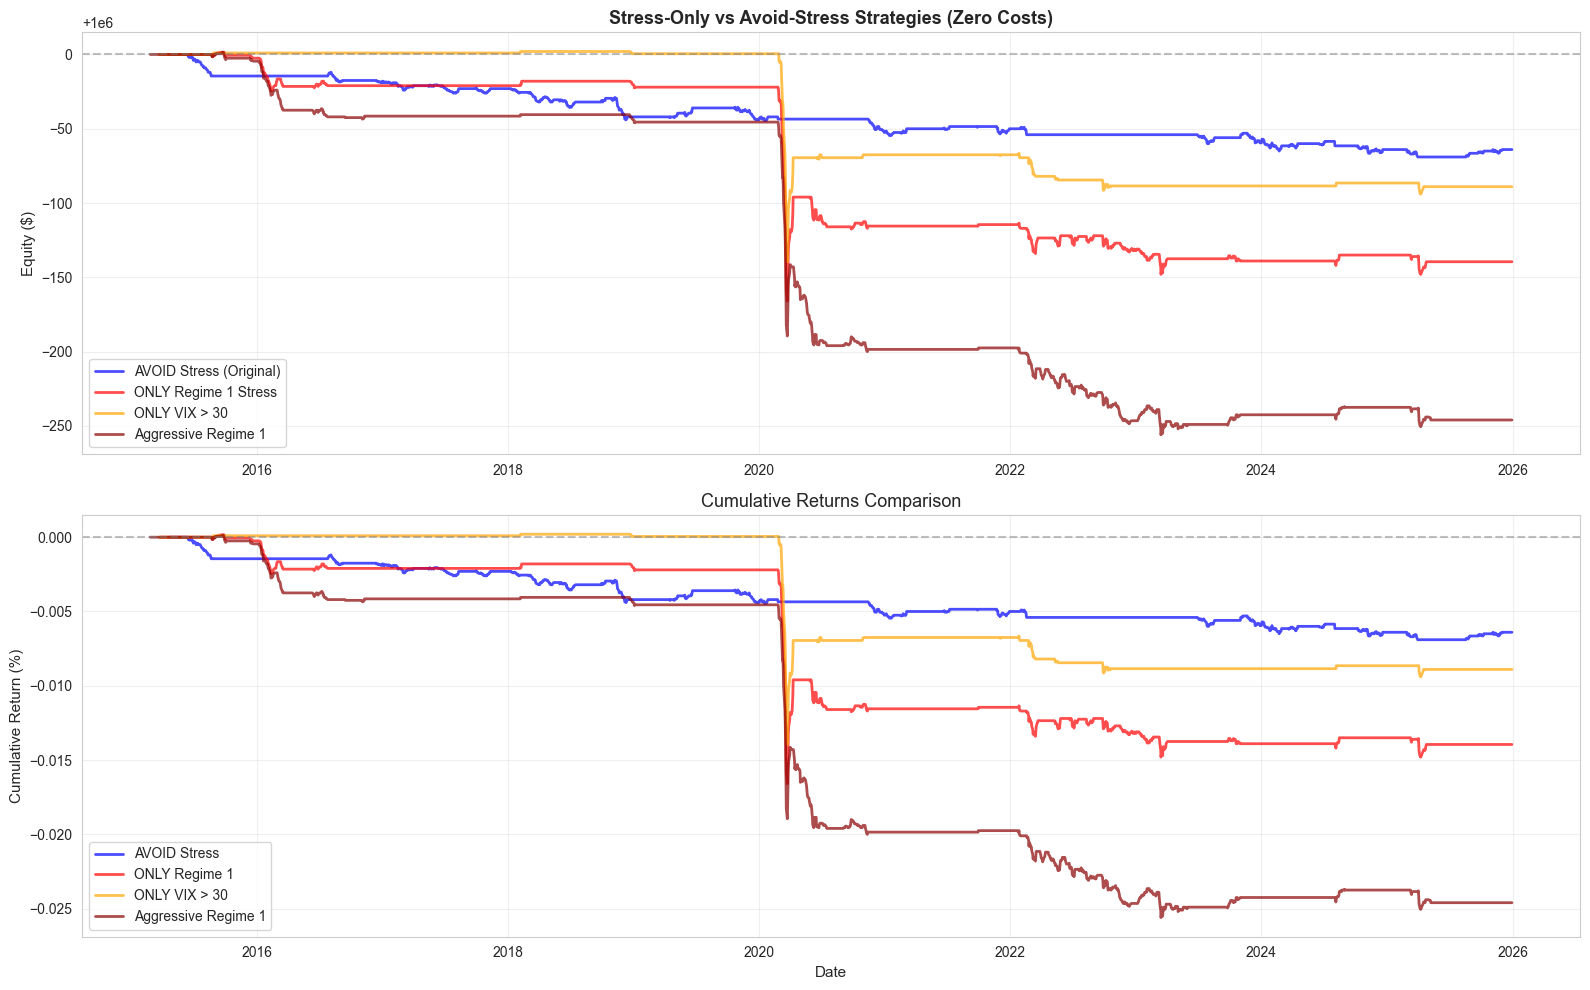

✓ Comparison complete


In [7]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Equity curves
axes[0].plot(results_avoid.index, results_avoid['equity'], 
             label='AVOID Stress (Original)', linewidth=2, color='blue', alpha=0.7)
axes[0].plot(results_regime.index, results_regime['equity'], 
             label='ONLY Regime 1 Stress', linewidth=2, color='red', alpha=0.7)
axes[0].plot(results_vix.index, results_vix['equity'], 
             label='ONLY VIX > 30', linewidth=2, color='orange', alpha=0.7)
axes[0].plot(results_aggressive.index, results_aggressive['equity'], 
             label='Aggressive Regime 1', linewidth=2, color='darkred', alpha=0.7)
axes[0].axhline(y=1_000_000, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Equity ($)', fontsize=11)
axes[0].set_title('Stress-Only vs Avoid-Stress Strategies (Zero Costs)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative returns
ret_avoid = (results_avoid['equity'] / 1_000_000 - 1) * 100
ret_regime = (results_regime['equity'] / 1_000_000 - 1) * 100
ret_vix = (results_vix['equity'] / 1_000_000 - 1) * 100
ret_agg = (results_aggressive['equity'] / 1_000_000 - 1) * 100

axes[1].plot(results_avoid.index, ret_avoid, label='AVOID Stress', linewidth=2, color='blue', alpha=0.7)
axes[1].plot(results_regime.index, ret_regime, label='ONLY Regime 1', linewidth=2, color='red', alpha=0.7)
axes[1].plot(results_vix.index, ret_vix, label='ONLY VIX > 30', linewidth=2, color='orange', alpha=0.7)
axes[1].plot(results_aggressive.index, ret_agg, label='Aggressive Regime 1', linewidth=2, color='darkred', alpha=0.7)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Cumulative Return (%)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_title('Cumulative Returns Comparison', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/stress_only_vs_avoid_stress.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison complete")